# **1. Import Library**

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import SimpleITK as sitk
import torch
import torch.nn as nn
import tensorflow as tf
from pathlib import Path
from PIL import Image
from scipy.fftpack import dct
from scipy.fft import fft2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from radiomics import featureextractor
import radiomics
from torchvision import models, transforms
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image

from sklearn.ensemble import RandomForestClassifier

import shap
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE, mutual_info_classif
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')

print(f"TensorFlow: {tf.__version__}")
print(f"PyTorch: {torch.__version__}")
print(f"Radiomics: {radiomics.__version__}")


TensorFlow: 2.19.0
PyTorch: 2.9.0+cu126
Radiomics: 3.1.1.dev111+g8ed579383


# **2. Dataset Loader**

In [ ]:
GRADCAM_DIR = Path('/content/drive/MyDrive/DATASET_GRADCAM_OUTPUT')
ORIGINAL_DATA_DIR = Path('/content/drive/MyDrive/Dataset_BUSI_with_GT')

MODEL_DENSENET121_PATH = Path('/content/drive/MyDrive/model_densenet121_humic.pth')
MODEL_DENSENET201_PATH = Path('/content/drive/MyDrive/DenseNet201_2.keras')
MODEL_RESNET50_PATH = Path('/content/drive/MyDrive/best_resnet50_medianfilter_fixed.keras')

OUTPUT_DIR = Path('/content/drive/MyDrive/fusion_results')
OUTPUT_DIR.mkdir(exist_ok=True)

CLASSES = ['benign', 'malignant', 'normal']
IMG_SIZE = (224, 224)
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
print(f"Output: {OUTPUT_DIR}")

Output: /content/drive/MyDrive/fusion_results


# **3. Helper Function**

In [ ]:
from pathlib import Path

def load_image_paths(data_dir):
    image_paths = []
    labels = []

    for class_name in CLASSES:
        class_dir = data_dir / class_name
        if not class_dir.exists():
            continue

        for root, _, files in os.walk(class_dir):
            for f in files:
                if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                    image_paths.append(str(Path(root) / f))
                    labels.append(class_name)

    return image_paths, labels


def create_image_mapping(original_paths, gradcam_paths):
    mapping = {}
    gradcam_dict = {}

    for p in gradcam_paths:
        stem = Path(p).stem
        clean_stem = stem.replace('BUSI_', '').replace('MENDELEY_', '').strip()
        gradcam_dict[clean_stem] = p

    for orig_path in original_paths:
        file_stem = Path(orig_path).stem
        if file_stem in gradcam_dict:
            mapping[orig_path] = gradcam_dict[file_stem]

    return mapping

# **4. Data Path Loader**

In [ ]:
print("Loading data paths...")
gradcam_paths, gradcam_labels = load_image_paths(GRADCAM_DIR)
original_paths, original_labels = load_image_paths(ORIGINAL_DATA_DIR)
image_mapping = create_image_mapping(original_paths, gradcam_paths)

print(f"Grad-CAM images: {len(gradcam_paths)}")
print(f"Original images: {len(original_paths)}")
print(f"Matched images: {len(image_mapping)}")

Loading data paths...
Grad-CAM images: 1030
Original images: 1030
Matched images: 1030


# **5. Radiomics Extraction**

In [ ]:
def extract_frequency_features(image_array, mask_array):
    pixels = image_array[mask_array == 1]

    if len(pixels) == 0:
        return {}

    x, y, w, h = cv2.boundingRect(mask_array.astype(np.uint8))
    roi_crop = image_array[y:y+h, x:x+w]
    roi_resized = cv2.resize(roi_crop, (64, 64))

    dct_coeffs = dct(dct(roi_resized.T, norm='ortho').T, norm='ortho')
    fft_coeffs = np.abs(fft2(roi_resized))

    feats = {}
    for name, coeffs in [('DCT', dct_coeffs), ('FFT', fft_coeffs)]:
        flat = coeffs.flatten()
        feats[f'{name}_Mean'] = np.mean(flat)
        feats[f'{name}_Variance'] = np.var(flat)
        feats[f'{name}_Energy'] = np.sum(flat**2)
        feats[f'{name}_Entropy'] = -np.sum((flat/np.sum(flat)) * np.log2(flat/np.sum(flat) + 1e-10))
        feats[f'{name}_Max'] = np.max(flat)
        feats[f'{name}_Min'] = np.min(flat)

    return feats

def extract_radiomics_advanced(orig_path, gradcam_path, extractor):
    try:
        img = cv2.imread(str(orig_path), cv2.IMREAD_GRAYSCALE)
        if img is None: return None

        gradcam = cv2.imread(str(gradcam_path), cv2.IMREAD_GRAYSCALE)
        if gradcam is None:
            _, mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        else:
            gradcam = cv2.resize(gradcam, (img.shape[1], img.shape[0]))
            _, mask = cv2.threshold(gradcam, 127, 1, cv2.THRESH_BINARY)

        if np.sum(mask) == 0:
            mask[0,0] = 1

        sitk_image = sitk.GetImageFromArray(img)
        sitk_mask = sitk.GetImageFromArray(mask)
        sitk_mask.CopyInformation(sitk_image)

        features = extractor.execute(sitk_image, sitk_mask)
        feature_dict = {k: v for k, v in features.items() if not k.startswith('diagnostics_')}

        freq_features = extract_frequency_features(img, mask)
        feature_dict.update(freq_features)
        return feature_dict
    except Exception as e:
        print(f'Error extracting {orig_path}: {e}')
        return None

In [ ]:
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.settings['binWidth'] = 25
extractor.settings['resampledPixelSpacing'] = None
extractor.settings['interpolator'] = sitk.sitkBSpline
extractor.enableImageTypeByName('Original')
extractor.enableImageTypeByName('Wavelet')

for fc in ['firstorder', 'glcm', 'glrlm', 'glszm', 'gldm', 'ngtdm']:
    extractor.enableFeatureClassByName(fc)

INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}


In [ ]:
radiomics_features_list = []
valid_image_paths = []
print("Mulai ekstraksi fitur Radiomics + Frekuensi...")
for i, (orig_path, gradcam_path) in enumerate(image_mapping.items()):
    if i % 50 == 0:
        print(f"Progress: {i}/{len(image_mapping)}")

    features = extract_radiomics_advanced(orig_path, gradcam_path, extractor)

    if features:
        radiomics_features_list.append(features)
        valid_image_paths.append(orig_path)

if radiomics_features_list:
    radiomics_df = pd.DataFrame(radiomics_features_list)
    radiomics_df['image_path'] = valid_image_paths
    output_path = OUTPUT_DIR / 'radiomics_features_advanced.csv'
    radiomics_df.to_csv(output_path, index=False)
    print(f"Selesai! Dimensi fitur: {radiomics_df.shape}")
    print(f"Disimpan di: {output_path}")
else:
    print("Tidak ada fitur yang berhasil diekstraksi.")


Mulai ekstraksi fitur Radiomics + Frekuensi...
Progress: 0/1030


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet LH
INFO:radiomics.featureextractor:Calculating features for wavelet-LH image
INFO:radiomics.featureextractor:Compu

Progress: 50/1030


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet LH
INFO:radiomics.featureextractor:Calculating features for wavelet-LH image
INFO:radiomics.featureextractor:Compu

Progress: 100/1030


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet LH
INFO:radiomics.featureextractor:Calculating features for wavelet-LH image
INFO:radiomics.featureextractor:Compu

Progress: 150/1030


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet LH
INFO:radiomics.featureextractor:Calculating features for wavelet-LH image
INFO:radiomics.featureextractor:Compu

Progress: 200/1030


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet LH
INFO:radiomics.featureextractor:Calculating features for wavelet-LH image
INFO:radiomics.featureextractor:Compu

Progress: 250/1030


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet LH
INFO:radiomics.featureextractor:Calculating features for wavelet-LH image
INFO:radiomics.featureextractor:Compu

Progress: 300/1030


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet LH
INFO:radiomics.featureextractor:Calculating features for wavelet-LH image
INFO:radiomics.featureextractor:Compu

Progress: 350/1030


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet LH
INFO:radiomics.featureextractor:Calculating features for wavelet-LH image
INFO:radiomics.featureextractor:Compu

Progress: 400/1030


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet LH
INFO:radiomics.featureextractor:Calculating features for wavelet-LH image
INFO:radiomics.featureextractor:Compu

Progress: 450/1030


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet LH
INFO:radiomics.featureextractor:Calculating features for wavelet-LH image
INFO:radiomics.featureextractor:Compu

Progress: 500/1030


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet LH
INFO:radiomics.featureextractor:Calculating features for wavelet-LH image
INFO:radiomics.featureextractor:Compu

Progress: 550/1030


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet LH
INFO:radiomics.featureextractor:Calculating features for wavelet-LH image
INFO:radiomics.featureextractor:Compu

Progress: 600/1030


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet LH
INFO:radiomics.featureextractor:Calculating features for wavelet-LH image
INFO:radiomics.featureextractor:Compu

Progress: 650/1030


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet LH
INFO:radiomics.featureextractor:Calculating features for wavelet-LH image
INFO:radiomics.featureextractor:Compu

Progress: 700/1030


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet LH
INFO:radiomics.featureextractor:Calculating features for wavelet-LH image
INFO:radiomics.featureextractor:Compu

Progress: 750/1030


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet LH
INFO:radiomics.featureextractor:Calculating features for wavelet-LH image
INFO:radiomics.featureextractor:Compu

Progress: 800/1030


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet LH
INFO:radiomics.featureextractor:Calculating features for wavelet-LH image
INFO:radiomics.featureextractor:Compu

Progress: 850/1030


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet LH
INFO:radiomics.featureextractor:Calculating features for wavelet-LH image
INFO:radiomics.featureextractor:Compu

Progress: 900/1030


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet LH
INFO:radiomics.featureextractor:Calculating features for wavelet-LH image
INFO:radiomics.featureextractor:Compu

Progress: 950/1030


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet LH
INFO:radiomics.featureextractor:Calculating features for wavelet-LH image
INFO:radiomics.featureextractor:Compu

Progress: 1000/1030


INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Adding image type "Wavelet" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.imageoperations:Computing Wavelet LH
INFO:radiomics.featureextractor:Calculating features for wavelet-LH image
INFO:radiomics.featureextractor:Compu

Selesai! Dimensi fitur: (1030, 478)
Disimpan di: /content/drive/MyDrive/fusion_results/radiomics_features_advanced.csv


# **6. Model Loader**

In [ ]:
def load_pytorch_densenet121(model_path, num_classes=3):
    try:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        checkpoint = torch.load(model_path, map_location=device)
        model = models.densenet121(weights=None)
        num_features = model.classifier.in_features
        model.classifier = nn.Linear(num_features, num_classes)

        if isinstance(checkpoint, dict):
            if 'model_state_dict' in checkpoint:
                model.load_state_dict(checkpoint['model_state_dict'], strict=False)
            else:
                model.load_state_dict(checkpoint, strict=False)
        else:
            model.load_state_dict(checkpoint, strict=False)

        feature_extractor = nn.Sequential(model.features, nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)))
        feature_extractor.eval()
        feature_extractor.to(device)
        print("PyTorch model loaded")
        return feature_extractor, device
    except Exception as e:
        print(f"Error: {e}")
        return None, None

def load_keras_model_for_features(model_path):
    try:
        model = load_model(str(model_path), compile=False)
        feature_layer = None
        for layer in reversed(model.layers):
            if 'global_average_pooling' in layer.name.lower() or ('dense' in layer.name.lower() and layer != model.layers[-1]):
                feature_layer = layer.name
                break
        if feature_layer is None:
            feature_layer = model.layers[-2].name
        feature_model = Model(inputs=model.input, outputs=model.get_layer(feature_layer).output)
        print(f"Keras model loaded (layer: {feature_layer})")
        return feature_model
    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
print("Loading models...")
model_dn121, device_dn121 = load_pytorch_densenet121(MODEL_DENSENET121_PATH)
model_dn201 = load_keras_model_for_features(MODEL_DENSENET201_PATH)
model_resnet = load_keras_model_for_features(MODEL_RESNET50_PATH)

Loading models...
PyTorch model loaded
Keras model loaded (layer: dense)
Keras model loaded (layer: dense_1)


# **7. Feature Extraction**

In [ ]:
def extract_features_pytorch(
    model,
    device,
    image_paths,
    img_size=(224, 224)
):
    model.eval()
    model.to(device)

    preprocess = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    features_list = []
    feature_dim = None

    for path in image_paths:
        try:
            img = Image.open(path).convert("RGB")
            x = preprocess(img).unsqueeze(0).to(device)

            with torch.no_grad():
                feat = model(x)

            feat = feat.view(-1).cpu().numpy()
            features_list.append(feat)

            if feature_dim is None:
                feature_dim = feat.shape[0]

        except (OSError, RuntimeError, ValueError):
            if feature_dim is None:
                feature_dim = 1
            features_list.append(np.zeros(feature_dim))

    return np.vstack(features_list)

def extract_features_keras(
    model,
    image_paths,
    preprocess_func,
    img_size=(224, 224)
):
    features_list = []
    feature_dim = None

    for path in image_paths:
        try:
            img = image.load_img(path, target_size=img_size)
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_func(img_array)

            feat = model.predict(img_array, verbose=0)
            feat = feat.flatten()
            features_list.append(feat)

            if feature_dim is None:
                feature_dim = feat.shape[0]

        except Exception:
            if feature_dim is None:
                # If the first image fails, set a default dimension or try to infer from model output shape if possible
                # For now, we will set to 1 if no successful feature extraction has occurred yet.
                feature_dim = 1000 # Placeholder, should be adjusted if a better way to get dim on error is found
            features_list.append(np.zeros(feature_dim))

    return np.vstack(features_list)

In [ ]:
deep_feats = {}

models_config = {
    "dn121": {
        "model": model_dn121,
        "type": "pytorch",
        "device": device_dn121,
        "preprocess": None
    },
    "dn201": {
        "model": model_dn201,
        "type": "keras",
        "preprocess": densenet_preprocess
    },
    "resnet": {
        "model": model_resnet,
        "type": "keras",
        "preprocess": resnet_preprocess
    }
}

for name, cfg in models_config.items():
    model = cfg["model"]
    if model is None:
        continue

    print(f"Extracting {name.upper()}...")

    if cfg["type"] == "pytorch":
        deep_feats[name] = extract_features_pytorch(
            model=model,
            device=cfg["device"],
            image_paths=valid_image_paths
        )
    else:
        deep_feats[name] = extract_features_keras(
            model=model,
            image_paths=valid_image_paths,
            preprocess_func=cfg["preprocess"]
        )


Extracting DN121...
Extracting DN201...
Extracting RESNET...


# **8. Deep Features 3 Best Model**

In [ ]:
from pathlib import Path
import numpy as np
from sklearn.preprocessing import LabelEncoder

print("\nFusing features...")

# --- Radiomics features ---
X_radiomics = radiomics_df.select_dtypes(include=[np.number]).to_numpy()
features_list = [X_radiomics]

print(f"Radiomics features shape: {X_radiomics.shape}")

# --- Deep features ---
for name, feats in deep_feats.items():
    feats = np.asarray(feats)

    # Pastikan bentuk (n_samples, n_features)
    if feats.ndim == 1:
        feats = feats.reshape(len(valid_image_paths), -1)

    features_list.append(feats)
    print(f"Deep feature [{name}] shape: {feats.shape}")

# --- Feature fusion ---
X_fused = np.concatenate(features_list, axis=1)
print(f"Total fused feature shape: {X_fused.shape}")

# --- Label extraction & encoding ---
raw_labels = [Path(p).parent.name for p in valid_image_paths]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(raw_labels)



Fusing features...
Radiomics features shape: (1030, 12)
Deep feature [dn121] shape: (1030, 1024)
Deep feature [dn201] shape: (1030, 256)
Deep feature [resnet] shape: (1030, 128)
Total fused feature shape: (1030, 1420)


# **9. Train & Test Data with Stratify**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np
from collections import Counter

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_fused,
    y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=RANDOM_SEED
)

print("\n=== DATA SPLIT SUMMARY ===")
print(f"Total samples : {X_fused.shape[0]}")
print(f"Train samples : {X_train.shape[0]} ({X_train.shape[0]/X_fused.shape[0]*100:.1f}%)")
print(f"Test samples  : {X_test.shape[0]} ({X_test.shape[0]/X_fused.shape[0]*100:.1f}%)")

print("\nClass distribution (Train):", Counter(y_train))
print("Class distribution (Test) :", Counter(y_test))

# --- Imputation ---
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# --- Scaling ---
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- Safety check for NaN ---
if np.isnan(X_train).any() or np.isnan(X_test).any():
    print("Warning: NaN detected after preprocessing. Replacing with zeros.")
    X_train = np.nan_to_num(X_train)
    X_test = np.nan_to_num(X_test)

print("\n=== DATA AFTER PREPROCESSING ===")
print(f"Train shape : {X_train.shape}")
print(f"Test shape  : {X_test.shape}")



=== DATA SPLIT SUMMARY ===
Total samples : 1030
Train samples : 824 (80.0%)
Test samples  : 206 (20.0%)

Class distribution (Train): Counter({np.int64(0): 430, np.int64(1): 288, np.int64(2): 106})
Class distribution (Test) : Counter({np.int64(0): 107, np.int64(1): 72, np.int64(2): 27})

=== DATA AFTER PREPROCESSING ===
Train shape : (824, 1419)
Test shape  : (206, 1419)


# **10. Feature Reduction**

In [ ]:
import lightgbm as lgbm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif

pca_results = {}
lgbm_fs_results = {}
anova_results = {}
mi_results = {}

print("\n=== PCA RESULTS SUMMARY ===")

for n in [50, 100, 200]:
    max_comp = min(X_train.shape)
    if n > max_comp:
        print(f"Skipping PCA-{n} (insufficient samples/features)")
        continue

    pca = PCA(n_components=n, random_state=RANDOM_SEED)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    cum_var = np.sum(pca.explained_variance_ratio_)

    pca_results[n] = {
        "transformer": pca,
        "X_train": X_train_pca,
        "X_test": X_test_pca,
        "cumulative_variance": cum_var
    }

    print(
        f"PCA-{n} | "
        f"Train: {X_train_pca.shape} | "
        f"Test: {X_test_pca.shape} | "
        f"Explained Var: {cum_var*100:.2f}%"
    )
print("\n=== ANOVA RESULTS SUMMARY ===")

for k in [50, 100, 200]:
    if k > X_train.shape[1]:
        print(f"Skipping ANOVA-{k}")
        continue

    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_sel = selector.fit_transform(X_train, y_train)
    X_test_sel = selector.transform(X_test)

    anova_results[k] = {
        "selector": selector,
        "X_train": X_train_sel,
        "X_test": X_test_sel
    }

    print(
        f"ANOVA-{k} | "
        f"Train: {X_train_sel.shape} | "
        f"Test: {X_test_sel.shape}"
    )

print("\n=== MUTUAL INFORMATION RESULTS SUMMARY ===")

for k in [50, 100, 200]:
    if k > X_train.shape[1]:
        print(f"Skipping MI-{k}")
        continue

    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    X_train_mi = selector.fit_transform(X_train, y_train)
    X_test_mi = selector.transform(X_test)

    mi_results[k] = {
        "selector": selector,
        "X_train": X_train_mi,
        "X_test": X_test_mi
    }

    print(
        f"MI-{k} | "
        f"Train: {X_train_mi.shape} | "
        f"Test: {X_test_mi.shape}"
    )

# Train LightGBM untuk mendapatkan feature importance
lgbm_fs_results = {}

lgb_selector = lgb.LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    random_state=RANDOM_SEED,
    class_weight="balanced",
    verbosity=-1
)

lgb_selector.fit(X_train, y_train)

importances = lgb_selector.feature_importances_
indices = np.argsort(importances)[::-1]

print("\n=== LIGHTGBM FEATURE SELECTION SUMMARY ===")

for k in [50, 100, 200]:
    if k > X_train.shape[1]:
        print(f"Skipping LightGBM-FS-{k}")
        continue

    top_k_idx = indices[:k]

    X_train_lgb = X_train[:, top_k_idx]
    X_test_lgb = X_test[:, top_k_idx]

    lgbm_fs_results[k] = {
        "feature_indices": top_k_idx,
        "X_train": X_train_lgb,
        "X_test": X_test_lgb
    }

    print(
        f"LightGBM-FS-{k} | "
        f"Train: {X_train_lgb.shape} | "
        f"Test: {X_test_lgb.shape}"
    )


=== PCA RESULTS SUMMARY ===
PCA-50 | Train: (824, 50) | Test: (206, 50) | Explained Var: 69.36%
PCA-100 | Train: (824, 100) | Test: (206, 100) | Explained Var: 78.84%
PCA-200 | Train: (824, 200) | Test: (206, 200) | Explained Var: 88.81%

=== ANOVA RESULTS SUMMARY ===
ANOVA-50 | Train: (824, 50) | Test: (206, 50)
ANOVA-100 | Train: (824, 100) | Test: (206, 100)
ANOVA-200 | Train: (824, 200) | Test: (206, 200)

=== MUTUAL INFORMATION RESULTS SUMMARY ===
MI-50 | Train: (824, 50) | Test: (206, 50)
MI-100 | Train: (824, 100) | Test: (206, 100)
MI-200 | Train: (824, 200) | Test: (206, 200)

=== LIGHTGBM FEATURE SELECTION SUMMARY ===
LightGBM-FS-50 | Train: (824, 50) | Test: (206, 50)
LightGBM-FS-100 | Train: (824, 100) | Test: (206, 100)
LightGBM-FS-200 | Train: (824, 200) | Test: (206, 200)


# **11. Classification (LightGBM)**

In [ ]:
lgbm_params = {
    "n_estimators": 300,
    "learning_rate": 0.05,
    "num_leaves": 15,
    "min_data_in_leaf": 10,
    "min_gain_to_split": 0.0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "class_weight": "balanced",
    "random_state": RANDOM_SEED,
    "n_jobs": -1,
    "verbosity": -1               #
}


clf_name = "LightGBM"
print(f"Classifier: {clf_name}")

# Simpan nama fitur original (sebelum feature reduction)
original_feature_names = [f"Feature_{i}" for i in range(X_fused.shape[1])]


Classifier: LightGBM


# **12. TRAINING & EVALUATION (LIGHTGBM)**

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

results = {}
trained_models = {}

for n_comp, data in pca_results.items():
    print(f"\nTraining {clf_name} on PCA-{n_comp}...")

    clf = lgb.LGBMClassifier(**lgbm_params)
    clf.fit(data['X_train'], y_train)

    y_pred = clf.predict(data['X_test'])

    results[f'PCA_{n_comp}'] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

    trained_models[f'PCA_{n_comp}'] = {
        'model': clf,
        'X_test': data['X_test'],
        'feature_names': [f'PC_{i}' for i in range(data['X_train'].shape[1])]
    }

    print(f"Accuracy: {results[f'PCA_{n_comp}']['accuracy']:.4f}")
    print(f"F1-Macro: {results[f'PCA_{n_comp}']['f1_macro']:.4f}")

for k, data in anova_results.items():
    print(f"\nTraining {clf_name} on ANOVA-{k}...")

    clf = lgb.LGBMClassifier(**lgbm_params)
    clf.fit(data['X_train'], y_train)

    y_pred = clf.predict(data['X_test'])

    results[f'ANOVA_{k}'] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

    mask = data['selector'].get_support()
    feat_names = [name for name, selected in zip(original_feature_names, mask) if selected]

    trained_models[f'ANOVA_{k}'] = {
        'model': clf,
        'X_test': data['X_test'],
        'feature_names': feat_names
    }

    print(f"Accuracy: {results[f'ANOVA_{k}']['accuracy']:.4f}")
    print(f"F1-Macro: {results[f'ANOVA_{k}']['f1_macro']:.4f}")

for k, data in mi_results.items():
    print(f"\nTraining {clf_name} on MutualInfo-{k}...")

    clf = lgb.LGBMClassifier(**lgbm_params)
    clf.fit(data['X_train'], y_train)

    y_pred = clf.predict(data['X_test'])

    results[f'MutualInfo_{k}'] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

    mask = data['selector'].get_support()
    feat_names = [name for name, selected in zip(original_feature_names, mask) if selected]

    trained_models[f'MutualInfo_{k}'] = {
        'model': clf,
        'X_test': data['X_test'],
        'feature_names': feat_names
    }

    print(f"Accuracy: {results[f'MutualInfo_{k}']['accuracy']:.4f}")
    print(f"F1-Macro: {results[f'MutualInfo_{k}']['f1_macro']:.4f}")


Training LightGBM on PCA-50...
Accuracy: 0.9466
F1-Macro: 0.9357

Training LightGBM on PCA-100...
Accuracy: 0.9563
F1-Macro: 0.9471

Training LightGBM on PCA-200...
Accuracy: 0.9417
F1-Macro: 0.9326

Training LightGBM on ANOVA-50...
Accuracy: 0.9466
F1-Macro: 0.9530

Training LightGBM on ANOVA-100...
Accuracy: 0.9660
F1-Macro: 0.9687

Training LightGBM on ANOVA-200...
Accuracy: 0.9563
F1-Macro: 0.9610

Training LightGBM on MutualInfo-50...
Accuracy: 0.9223
F1-Macro: 0.9252

Training LightGBM on MutualInfo-100...
Accuracy: 0.9612
F1-Macro: 0.9648

Training LightGBM on MutualInfo-200...
Accuracy: 0.9612
F1-Macro: 0.9648


In [ ]:
# === COMPARISON & LEADERBOARD (CLEAN VERSION) ===
comparison_df = pd.DataFrame.from_dict(results, orient="index")
comparison_df.reset_index(inplace=True)
comparison_df.rename(columns={"index": "Method"}, inplace=True)

comparison_df = comparison_df[[
    "Method", "accuracy", "f1_macro", "f1_weighted"
]]

comparison_df.columns = [
    "Method", "Accuracy", "F1_Macro", "F1_Weighted"
]

comparison_df = comparison_df.sort_values(
    by="F1_Macro", ascending=False
).reset_index(drop=True)

print("\n" + "="*70)
print(f" LIGHTGBM PERFORMANCE LEADERBOARD ".center(70))
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70 + "\n")

# Save
comparison_csv_path = OUTPUT_DIR / f"{clf_name}_leaderboard.csv"
comparison_df.to_csv(comparison_csv_path, index=False)
print(f"✓ Leaderboard saved to: {comparison_csv_path}")



                   LIGHTGBM PERFORMANCE LEADERBOARD                   
        Method  Accuracy  F1_Macro  F1_Weighted
     ANOVA_100  0.966019  0.968660     0.965879
MutualInfo_100  0.961165  0.964803     0.961038
MutualInfo_200  0.961165  0.964803     0.961038
     ANOVA_200  0.956311  0.960964     0.956209
      ANOVA_50  0.946602  0.952965     0.946347
       PCA_100  0.956311  0.947128     0.955858
        PCA_50  0.946602  0.935713     0.946215
       PCA_200  0.941748  0.932590     0.941467
 MutualInfo_50  0.922330  0.925227     0.922217

✓ Leaderboard saved to: /content/drive/MyDrive/fusion_results/LightGBM_leaderboard.csv



📊 Generating Confusion Matrices...


✓ Confusion matrices saved to: /content/drive/MyDrive/fusion_results/LightGBM_confusion_matrices.png


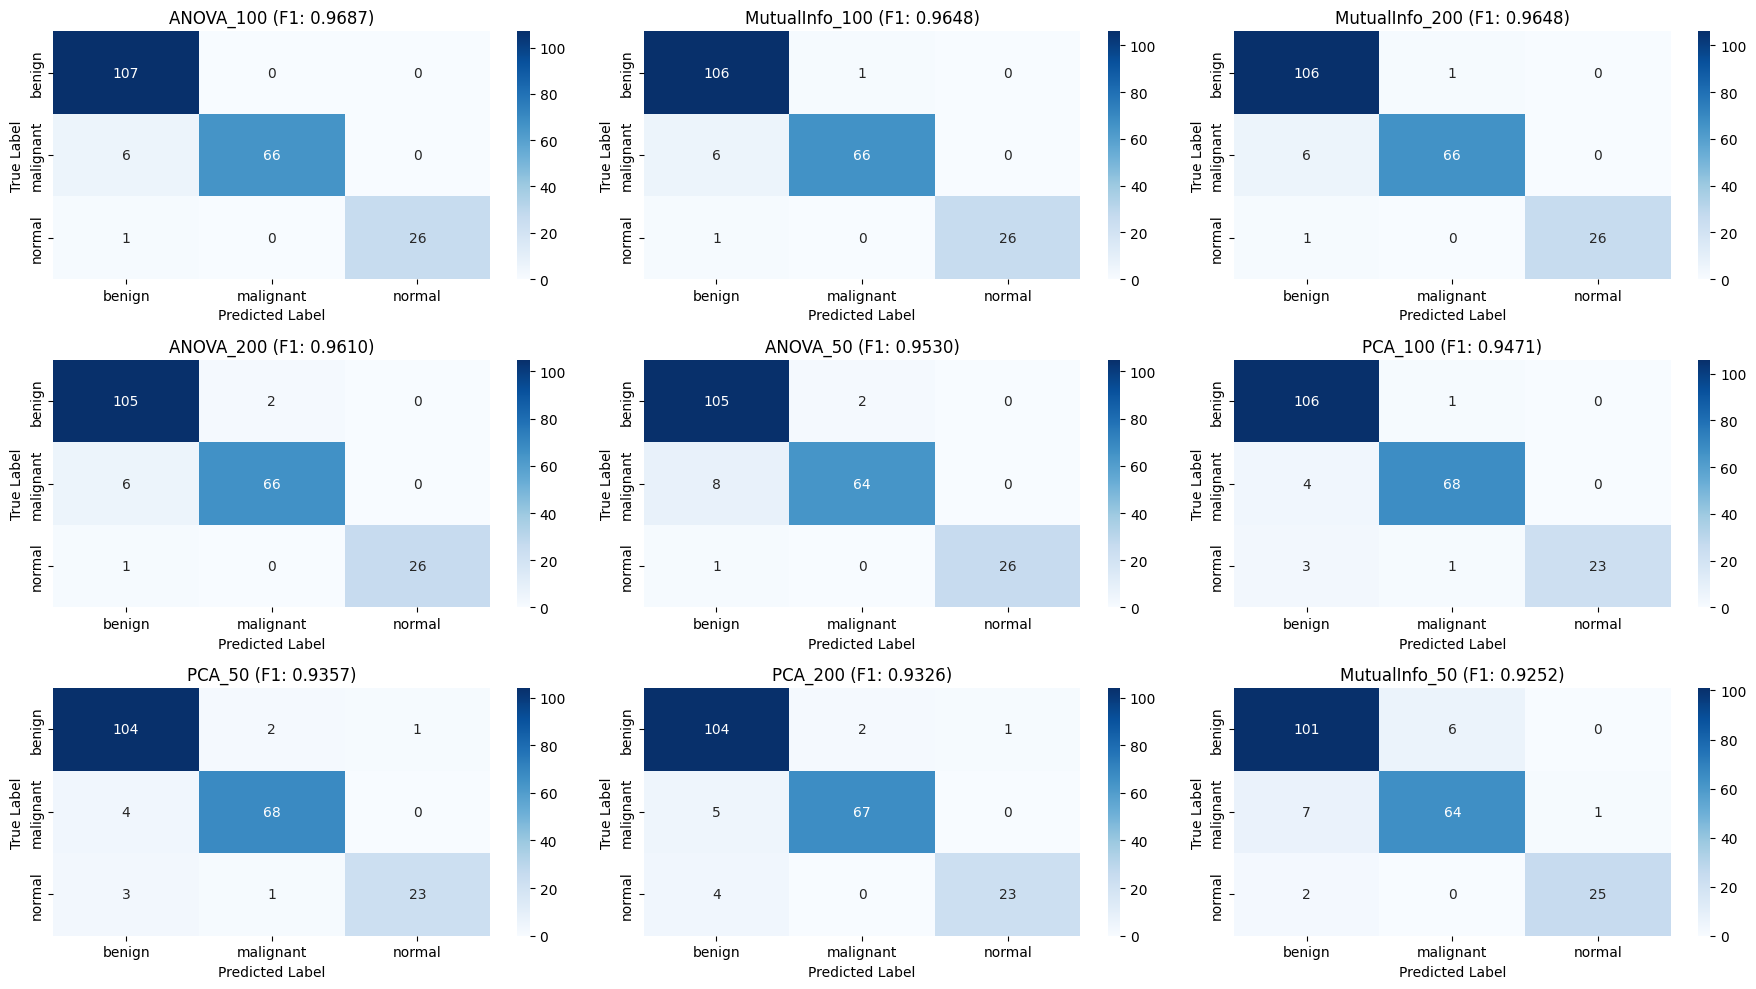

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(18, 10))
axes = axes.flatten()

# Get the top 6 methods from the comparison_df
top_methods = comparison_df['Method'].head(9).tolist()

print("\n" + "="*60)
print("📊 Generating Confusion Matrices...")
print("="*60 + "\n")

for idx, method in enumerate(top_methods):
    result = results[method]
    sns.heatmap(
        result['confusion_matrix'],
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_,
        ax=axes[idx]
    )
    axes[idx].set_title(f"{method} (F1: {result['f1_macro']:.4f})")
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
confusion_matrix_path = OUTPUT_DIR / f'{clf_name}_confusion_matrices.png'
plt.savefig(confusion_matrix_path, dpi=150)
print(f"\n✓ Confusion matrices saved to: {confusion_matrix_path}")
plt.show()

In [ ]:
# Define missing variables for the SHAP visualization code

# Get the best performing method and its information
best_method_name = comparison_df.iloc[0]['Method']
best_model_info = trained_models[best_method_name]

# Extract X_test and feature names for the best model
X_explain = best_model_info['X_test']
best_feature_names = best_model_info['feature_names']

# Create a directory to save SHAP outputs
shap_output_dir = OUTPUT_DIR / "shap_visualizations"
shap_output_dir.mkdir(exist_ok=True)

print(f"Using best model: {best_method_name}")
print(f"SHAP visualizations will be saved to: {shap_output_dir}")


Using best model: ANOVA_100
SHAP visualizations will be saved to: /content/drive/MyDrive/fusion_results/shap_visualizations


# **13. Explainable AI (SHAP)**


📊 Generating SHAP Visualizations...

1. Creating Summary Plot (Feature Importance)...
   ✓ Saved: /content/drive/MyDrive/fusion_results/shap_visualizations/shap_summary_ANOVA_100_class_0_benign.png


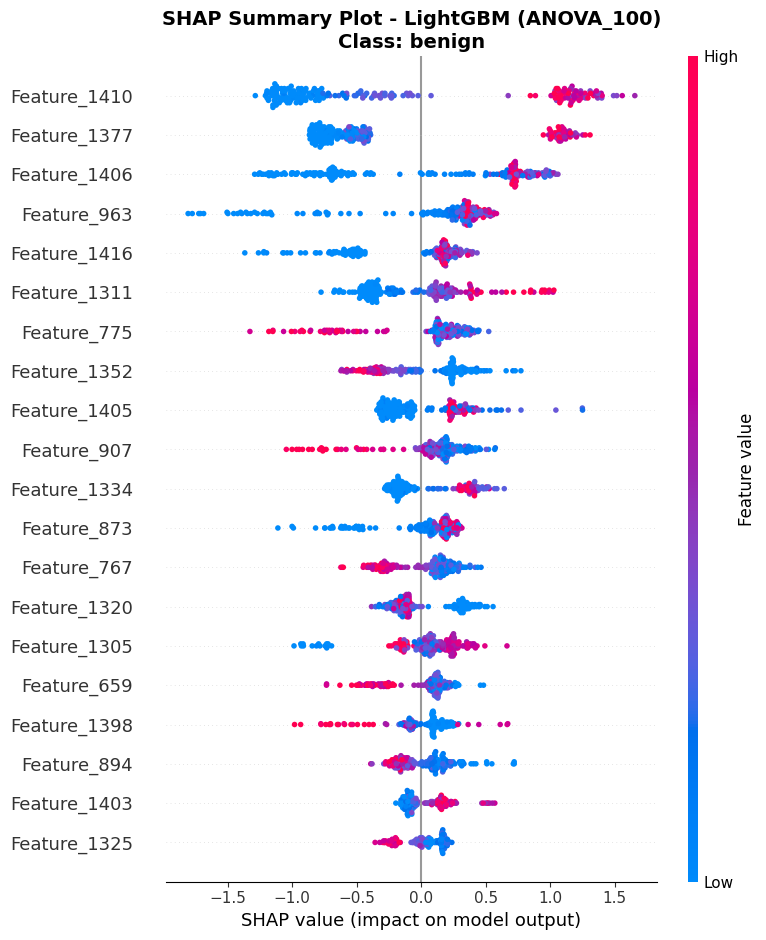

   ✓ Saved: /content/drive/MyDrive/fusion_results/shap_visualizations/shap_summary_ANOVA_100_class_1_malignant.png


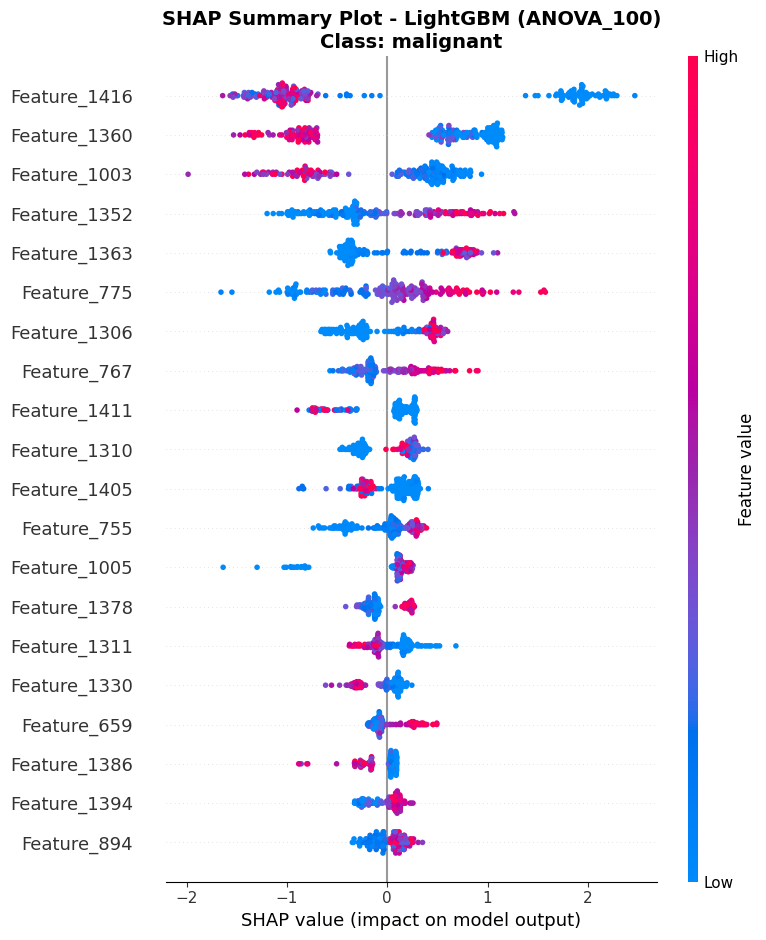

   ✓ Saved: /content/drive/MyDrive/fusion_results/shap_visualizations/shap_summary_ANOVA_100_class_2_normal.png


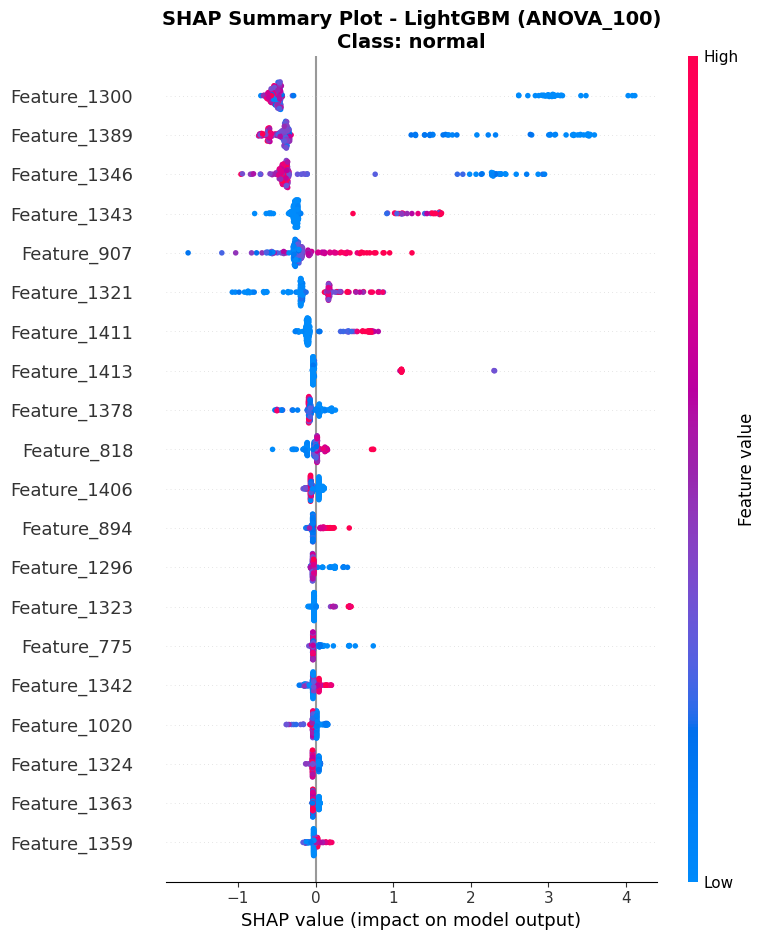


2. Creating Bar Plot (Mean Feature Importance)...
   ✓ Saved: /content/drive/MyDrive/fusion_results/shap_visualizations/shap_bar_ANOVA_100.png


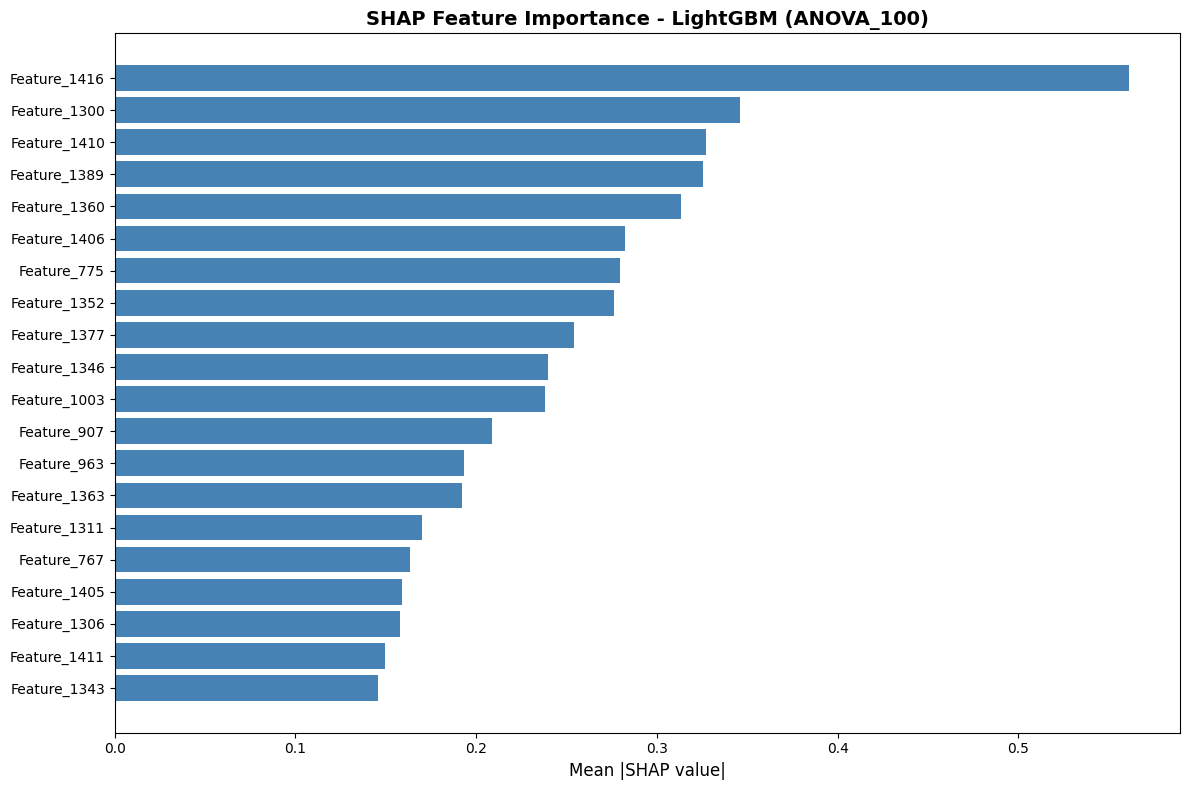

In [ ]:
print(f"\n{'='*60}")
print("📊 Generating SHAP Visualizations...")
print(f"{'='*60}\n")

# Plot 1: Summary Plot (Bee Swarm) untuk setiap kelas
print("1. Creating Summary Plot (Feature Importance)...")

if isinstance(shap_values, list) or (isinstance(shap_values, np.ndarray) and shap_values.ndim == 3):
    # Multi-class output
    for class_idx, class_name in enumerate(CLASSES):
        plt.figure(figsize=(12, 8))

        # Ambil SHAP values untuk kelas ini
        if isinstance(shap_values, list):
            class_shap = shap_values[class_idx]
        else:
            class_shap = shap_values[:, :, class_idx]

        shap.summary_plot(
            class_shap,
            X_explain,
            feature_names=best_feature_names,
            show=False,
            max_display=20
        )
        plt.title(f'SHAP Summary Plot - {clf_name} ({best_method_name})\nClass: {class_name}',
                  fontsize=14, fontweight='bold')
        plt.tight_layout()
        summary_plot_path = shap_output_dir / f'shap_summary_{best_method_name}_class_{class_idx}_{class_name}.png'
        plt.savefig(summary_plot_path, dpi=300, bbox_inches='tight')
        print(f"   ✓ Saved: {summary_plot_path}")
        plt.show()
        plt.close()
else:
    # Binary classification
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values,
        X_explain,
        feature_names=best_feature_names,
        show=False,
        max_display=20
    )
    plt.title(f'SHAP Summary Plot - {clf_name} ({best_method_name})',
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    summary_plot_path = shap_output_dir / f'shap_summary_{best_method_name}.png'
    plt.savefig(summary_plot_path, dpi=300, bbox_inches='tight')
    print(f"   ✓ Saved: {summary_plot_path}")
    plt.show()
    plt.close()

# Plot 2: Bar Plot (Mean Absolute SHAP Values)
print("\n2. Creating Bar Plot (Mean Feature Importance)...")
plt.figure(figsize=(12, 8))

if isinstance(shap_values, list):
    # Rata-rata SHAP values dari semua kelas
    # shap_values is a list of arrays, one per class. Each array is (n_samples, n_features).
    # We need to compute mean absolute SHAP for each feature across all classes.
    abs_shap_values_per_class = [np.abs(sv).mean(axis=0) for sv in shap_values]
    shap_values_combined = np.mean(abs_shap_values_per_class, axis=0)

    # Manual bar plot is safer and more flexible here
    feature_importance = pd.DataFrame({
        'feature': best_feature_names,
        'importance': shap_values_combined
    }).sort_values('importance', ascending=True).tail(20)

    plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
    plt.xlabel('Mean |SHAP value|', fontsize=12)
    plt.title(f'SHAP Feature Importance - {clf_name} ({best_method_name})',
              fontsize=14, fontweight='bold')

elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    # Shape: (n_samples, n_features, n_classes)
    shap_values_combined = np.abs(shap_values).mean(axis=(0, 2))

    # Manual bar plot karena shap.summary_plot mungkin error dengan format ini
    feature_importance = pd.DataFrame({
        'feature': best_feature_names,
        'importance': shap_values_combined
    }).sort_values('importance', ascending=True).tail(20)

    plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
    plt.xlabel('Mean |SHAP value|', fontsize=12)
    plt.title(f'SHAP Feature Importance - {clf_name} ({best_method_name})',
              fontsize=14, fontweight='bold')
else:
    shap.summary_plot(
        shap_values,
        X_explain,
        feature_names=best_feature_names,
        plot_type='bar',
        show=False,
        max_display=20
    )
    plt.title(f'SHAP Feature Importance - {clf_name} ({best_method_name})',
              fontsize=14, fontweight='bold')

plt.tight_layout()
bar_plot_path = shap_output_dir / f'shap_bar_{best_method_name}.png'
plt.savefig(bar_plot_path, dpi=300, bbox_inches='tight')
print(f"   ✓ Saved: {bar_plot_path}")
plt.show()
plt.close()

In [ ]:
summary = f"""Results Summary
Dataset: {len(valid_image_paths)} images
Classes: {', '.join(label_encoder.classes_)}
Train: {len(X_train)} Test: {len(X_test)}
Radiomics features: {X_radiomics.shape[1]}
Total fused features: {X_fused.shape[1]}
Classifier: {clf_name}
Best method: {best_method_name}
F1-Macro: {comparison_df.iloc[0]['F1_Macro']:.4f}
Accuracy: {comparison_df.iloc[0]['Accuracy']:.4f}
"""
print(summary)
with open(OUTPUT_DIR / 'summary_report.txt', 'w') as f:
    f.write(summary)

print(f"\nResults saved to: {OUTPUT_DIR}")
print("\nGenerated files:")
for file in OUTPUT_DIR.glob('*'):
    print(f"  {file.name}")

print("\nPipeline completed!")

Results Summary
Dataset: 1030 images
Classes: benign, malignant, normal
Train: 824 Test: 206
Radiomics features: 12
Total fused features: 1420
Classifier: LightGBM
Best method: ANOVA_100
F1-Macro: 0.9687
Accuracy: 0.9660


Results saved to: /content/drive/MyDrive/fusion_results

Generated files:
  radiomics_features_advanced.csv
  LightGBM_leaderboard.csv
  shap_visualizations
  LightGBM_confusion_matrices.png
  summary_report.txt

Pipeline completed!


# **14. Save Model**

In [ ]:
import joblib

print(f"\n--- Saving Best Model Pipeline: {best_method_name} ---")

method_type, param_val = best_method_name.split("_")
param_val = int(param_val)

final_reducer = None
X_train_final = None

if method_type == "PCA":
    final_reducer = pca_results[param_val]["transformer"]
    X_train_final = pca_results[param_val]["X_train"]
    print(f"Loaded reducer: PCA ({param_val} components)")

elif method_type == "ANOVA":
    final_reducer = anova_results[param_val]["selector"]
    X_train_final = anova_results[param_val]["X_train"]
    print(f"Loaded reducer: SelectKBest ANOVA ({param_val} features)")

elif method_type == "MutualInfo":
    final_reducer = mi_results[param_val]["selector"]
    X_train_final = mi_results[param_val]["X_train"]
    print(f"Loaded reducer: SelectKBest MutualInfo ({param_val} features)")

print("Retraining final LightGBM model...")

final_model = lgb.LGBMClassifier(**lgbm_params)
final_model.fit(X_train_final, y_train)

model_bundle = {
    "model_name": "LightGBM",
    "best_method": best_method_name,
    "scaler": scaler,                  # WAJIB (karena Anda scaling sebelumnya)
    "reducer": final_reducer,           # PCA / ANOVA / MI
    "classifier": final_model,          # LightGBM final
    "label_encoder": label_encoder,     # Encoder label kelas
    "feature_names": best_feature_names # Untuk SHAP & interpretasi
}

save_path = OUTPUT_DIR / "best_lightgbm_pipeline.joblib"
joblib.dump(model_bundle, save_path)

print(f"✅ Best LightGBM pipeline saved to: {save_path}")
print("Pipeline siap digunakan untuk prediksi data baru dan SHAP.")



--- Saving Best Model Pipeline: ANOVA_100 ---
Loaded reducer: SelectKBest ANOVA (100 features)
Retraining final LightGBM model...
✅ Best LightGBM pipeline saved to: /content/drive/MyDrive/fusion_results/best_lightgbm_pipeline.joblib
Pipeline siap digunakan untuk prediksi data baru dan SHAP.
